# Set up

In [105]:
import duckdb
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [106]:
movie_input = pd.read_csv('/Users/iliasxenogiannis/Documents/GitHub/box-office-prediction/data/processed_data/movie.csv')
genres = pd.read_csv('/Users/iliasxenogiannis/Documents/GitHub/box-office-prediction/data/processed_data/genre.csv')
keywords = pd.read_csv('/Users/iliasxenogiannis/Documents/GitHub/box-office-prediction/data/processed_data/keyword.csv')
production_companies = pd.read_csv('/Users/iliasxenogiannis/Documents/GitHub/box-office-prediction/data/processed_data/production.csv')

In [107]:
movie = movie_input[['movie_id','imdb_id','year','release_date','quarter','original_title',
                     'is_released', 'is_released_US','days_from_us_release',
                     'runtime','revenue_usd_adj','budget_usd_adj','surplus','ratio_adj','roi']]

In [108]:
movie['is_first_released_in_cinemas'] = np.where(movie['days_from_us_release'] > 0, 1, 0).astype(bool)
movie['is_first_released_in_cinemas_safe'] = np.where(movie['days_from_us_release'] > 60, 1, 0).astype(bool)
movie['is_released'] = movie['is_released'].astype(bool)

conditions = [
    (movie['is_released']) & (~movie['is_first_released_in_cinemas']),
    (movie['is_released']) & (movie['is_first_released_in_cinemas_safe']),
    (movie['is_released']) & (movie['is_first_released_in_cinemas']) & (~movie['is_first_released_in_cinemas_safe']),
    ~movie['is_released']
]

# Define the corresponding categories for each condition
categories = [
    'Streaming release',
    'Far streaming release',
    'Close streaming release',
    'Not released in major markets'
]

# Create the new categorical column
movie['release_category'] = np.select(conditions, categories, default='Other')
movie['is_within_scope'] = np.where((movie['budget_usd_adj'] > 10000) & (movie['revenue_usd_adj']>10000) , 1, 0).astype(bool)

# Basic Understanding of the Data

In [109]:
movie.head(5)

movie_id    imdb_id  year               release_date  quarter  \
0     47652  tt0865925  2006  2006-09-01 00:00:00+00:00        3   
1    127316  tt1017437  2008  2008-01-01 00:00:00+00:00        1   
2     80679  tt1217259  2010  2010-05-14 00:00:00+00:00        2   
3     25149  tt0407814  2006  2006-04-27 00:00:00+00:00        2   
4    212968  tt2276023  2013  2013-04-05 00:00:00+00:00        2   

                original_title  is_released is_released_US  \
0                 Off the Grid         True           True   
1           Gigantes de Valdés        False          False   
2        In/Significant Others         True           True   
3               Full Grown Men        False          False   
4  The United States of Autism         True           True   

   days_from_us_release  runtime  revenue_usd_adj  budget_usd_adj  \
0                9999.0      110    317186.631176    1.161329e+06   
1                9999.0      100    114851.554437    6.116717e+05   
2                9999.0      100      5050.357546    1.342109e+05   
3                9999.0       78     19910.991964    2.903323e+06   
4                9999.0       93    126132.462064    8.165702e+04   

        surplus  ratio_adj       roi  is_first_released_in_cinemas  \
0 -1.002736e+06   0.273124 -0.863438                          True   
1 -5.542459e+05   0.187767 -0.906117                          True   
2 -1.316858e+05   0.037630 -0.981185                          True   
3 -2.893368e+06   0.006858 -0.996571                          True   
4 -1.859079e+04   1.544662 -0.227669                          True   

   is_first_released_in_cinemas_safe               release_category  \
0                               True          Far streaming release   
1                               True  Not released in major markets   
2                               True          Far streaming release   
3                               True  Not released in major markets   
4                               True          Far streaming release   

   is_within_scope  
0             True  
1             True  
2            False  
3             True  
4             True

In [110]:
# Percentage of null values in each column for the entire dataset
null_percentage_all = movie.isnull().mean() * 100

# Percentage of zero values in each column for the entire dataset
zero_percentage_all = (movie == 0).mean() * 100

# Combining the results into a DataFrame for better visualization
null_zero_percentage_all = pd.DataFrame({'Null Percentage': null_percentage_all, 'Zero Percentage': zero_percentage_all})
print(null_zero_percentage_all)

                                   Null Percentage  Zero Percentage
movie_id                                   0.00000         0.000000
imdb_id                                    0.00000         0.000000
year                                       0.00000         0.000000
release_date                               0.00000         0.000000
quarter                                    0.00000         0.000000
original_title                             0.00000         0.000000
is_released                                0.00000        19.737478
is_released_US                             0.05637        27.870833
days_from_us_release                       0.05637         0.499275
runtime                                    0.00000         0.000000
revenue_usd_adj                            0.00000         0.000000
budget_usd_adj                             0.00000         0.120792
surplus                                    0.00000         0.000000
ratio_adj                                  0.000

In [111]:
movie = movie[movie['budget_usd_adj'] != 0]

In [112]:
formatted_description = movie.describe().style.format("{:,.2f}")
display(formatted_description)

In [113]:
# Print id title of the worst ( small and big ( not infinity ) ) ratio movies, can you format the numbers to be more readable?
print('Smallest ratio movies')
display(movie.sort_values(by='ratio_adj').head(5)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'ratio_adj']])

print('Biggest ratio movies')
display(movie[movie.budget_usd_adj != 0 ].sort_values(by='ratio_adj', ascending=False).head(5)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'ratio_adj']])


Smallest ratio movies


movie_id   original_title  revenue_usd_adj  budget_usd_adj  ratio_adj
11283     82743           Inbred        31.224999    2.533889e+06   0.000012
801      421888   Corazón muerto        15.851683    1.219360e+06   0.000013
3389     220958  Örnjägarens son        31.374844    2.278632e+06   0.000014
964       41393      Zyzzyx Road        43.549851    2.903323e+06   0.000015
8265      14330       Trojan War       563.429252    2.735093e+07   0.000021

Biggest ratio movies


movie_id original_title  revenue_usd_adj  budget_usd_adj     ratio_adj
3330      89584     Fetih 1453     4.562917e+07       22.943936  1.988725e+06
3094     438731        விவேகம்     1.375298e+06        1.193925  1.151913e+06
12140    406429           封神传奇     5.304067e+07       46.335690  1.144704e+06
2651     288313         Perez.     1.225693e+06        1.236208  9.914940e+05
1583      53128     Ψυχή Βαθιά     2.903065e+06        4.092371  7.093847e+05

In [114]:
# Movies with ratio_adj > more than 10 and less than 0.1
print('Movies with ratio_adj > more than 10 and less than 0.1')
display(movie[(movie.ratio_adj > 10) | (movie.ratio_adj < 0.1)][['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'ratio_adj']])
# Save them in a csv file
movie[(movie.ratio_adj > 10) | (movie.ratio_adj < 0.1)][['movie_id','imdb_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'ratio_adj']].to_csv('/Users/iliasxenogiannis/Documents/GitHub/box-office-prediction/data/processed_data/movies_susp_ratio_adj.csv')

Movies with ratio_adj > more than 10 and less than 0.1


movie_id                      original_title  revenue_usd_adj  \
2         80679               In/Significant Others      5050.357546   
3         25149                      Full Grown Men     19910.991964   
5         55748                      Ystäväni Henry     58077.067152   
7        213020  El efecto K: el montador de Stalin       427.129041   
14       123205               13 Months of Sunshine      3298.582704   
...         ...                                 ...              ...   
12397    273271                          Time Lapse     24195.068177   
12401    345775               Tout en haut du monde     74519.188750   
12407      8374                 The Boondock Saints     53526.353571   
12413     29514                 Due occhi diabolici    782842.048891   
12417      9696                                殺し屋1    133241.475466   

       budget_usd_adj  ratio_adj  
2        1.342109e+05   0.037630  
3        2.903323e+06   0.006858  
5        3.237657e+06   0.017938  
7        1.265464e+06   0.000338  
14       7.763032e+04   0.042491  
...               ...        ...  
12397    6.181041e+06   0.003914  
12401    8.107073e+06   0.009192  
12407    1.053980e+07   0.005078  
12413    2.015222e+07   0.038846  
12417    2.313478e+06   0.057594  

[3425 rows x 5 columns]

Example of outlier, indeed a wrong imdb data entry

https://www.imdb.com/title/tt1334328/


movie_id	original_title	revenue_usd_adj	budget_usd_adj	ratio_adj

53128	Ψυχή Βαθιά	2.903065e+06	4.092371	7.093847e+0

In [115]:
# Print id title of the worst ( small and big ( not infinity ) ) ratio movies, can you format the numbers to be more readable?
print('Smallest ROI movies')
display(movie.sort_values(by='roi').head(5)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'ratio_adj', 'roi']])

print('Biggest ROI movies')
display(movie[movie.budget_usd_adj != 0 ].sort_values(by='roi', ascending=False).head(5)[['movie_id', 'original_title', 'revenue_usd_adj','budget_usd_adj', 'ratio_adj', 'roi']])


Smallest ROI movies


movie_id   original_title  revenue_usd_adj  budget_usd_adj  ratio_adj  \
11283     82743           Inbred        31.224999    2.533889e+06   0.000012   
801      421888   Corazón muerto        15.851683    1.219360e+06   0.000013   
3389     220958  Örnjägarens son        31.374844    2.278632e+06   0.000014   
964       41393      Zyzzyx Road        43.549851    2.903323e+06   0.000015   
8265      14330       Trojan War       563.429252    2.735093e+07   0.000021   

            roi  
11283 -0.999994  
801   -0.999993  
3389  -0.999993  
964   -0.999992  
8265  -0.999990

Biggest ROI movies


movie_id original_title  revenue_usd_adj  budget_usd_adj     ratio_adj  \
3330      89584     Fetih 1453     4.562917e+07       22.943936  1.988725e+06   
3094     438731        விவேகம்     1.375298e+06        1.193925  1.151913e+06   
12140    406429           封神传奇     5.304067e+07       46.335690  1.144704e+06   
2651     288313         Perez.     1.225693e+06        1.236208  9.914940e+05   
1583      53128     Ψυχή Βαθιά     2.903065e+06        4.092371  7.093847e+05   

                 roi  
3330   994361.361111  
3094   575955.500000  
12140  572351.184211  
2651   495746.000000  
1583   354691.333333

In [116]:
# Can you give some basic statistics per genre for the ratio and the ROI?
print('Basic statistics per is_released_US flag for the ratio and the ROI: ')
display(movie.groupby('is_released_US')[['ratio_adj', 'roi']].describe().style.format("{:,.2f}"))

Basic statistics per is_released_US flag for the ratio and the ROI: 


In [117]:
# Some basic statistics per release type for the ratio and the ROI
print('Basic statistics per release_category for the ratio and the ROI: ')
display(movie.groupby('release_category')[['ratio_adj', 'roi']].describe().style.format("{:,.2f}"))

Basic statistics per release_category for the ratio and the ROI: 


In [118]:
# Some basic statistics per release type for the ratio and the ROI
print('Basic statistics per release_category / within scope for the ratio and the ROI: ')
display(movie.groupby(['is_within_scope','release_category'])[['ratio_adj', 'roi']].describe().style.format("{:,.2f}"))

Basic statistics per release_category / within scope for the ratio and the ROI: 


In [119]:
movie[movie.original_title == 'The Irishman']

movie_id    imdb_id  year               release_date  quarter  \
10659    398978  tt1302006  2019  2019-11-01 00:00:00+00:00        4   

      original_title  is_released is_released_US  days_from_us_release  \
10659   The Irishman         True           True                  26.0   

       runtime  revenue_usd_adj  budget_usd_adj       surplus  ratio_adj  \
10659      209     1.109063e+06    1.820101e+08 -1.814555e+08   0.006093   

            roi  is_first_released_in_cinemas  \
10659 -0.996953                          True   

       is_first_released_in_cinemas_safe         release_category  \
10659                              False  Close streaming release   

       is_within_scope  
10659             True

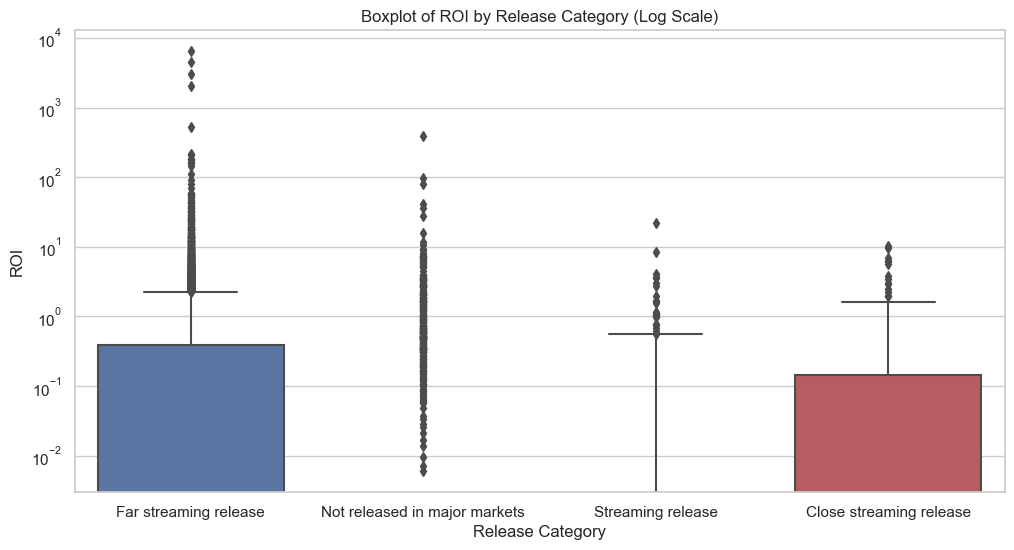

In [120]:
# Assuming 'movie' is your DataFrame and it already has 'release_category' and 'roi' columns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(x='release_category', y='roi', data=movie[movie.is_within_scope])
plt.yscale('log')
plt.title('Boxplot of ROI by Release Category (Log Scale)')
plt.xlabel('Release Category')
plt.ylabel('ROI')
plt.show()


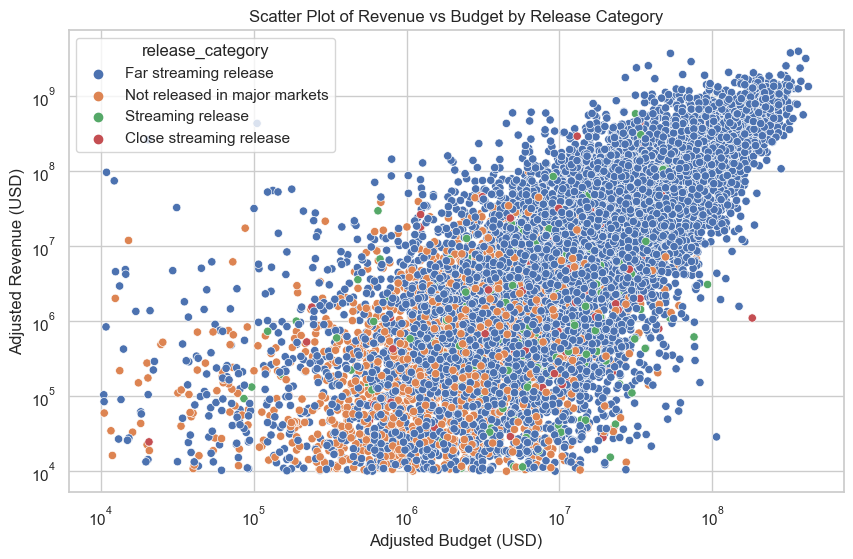

In [121]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
scatter = sns.scatterplot(x='budget_usd_adj', y='revenue_usd_adj', hue='release_category', data=movie[movie['is_within_scope'] == True])

# Adding plot title and labels
plt.title('Scatter Plot of Revenue vs Budget by Release Category')
plt.xlabel('Adjusted Budget (USD)')
plt.ylabel('Adjusted Revenue (USD)')

# Optional: Set log scale for better visibility if numbers vary a lot
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

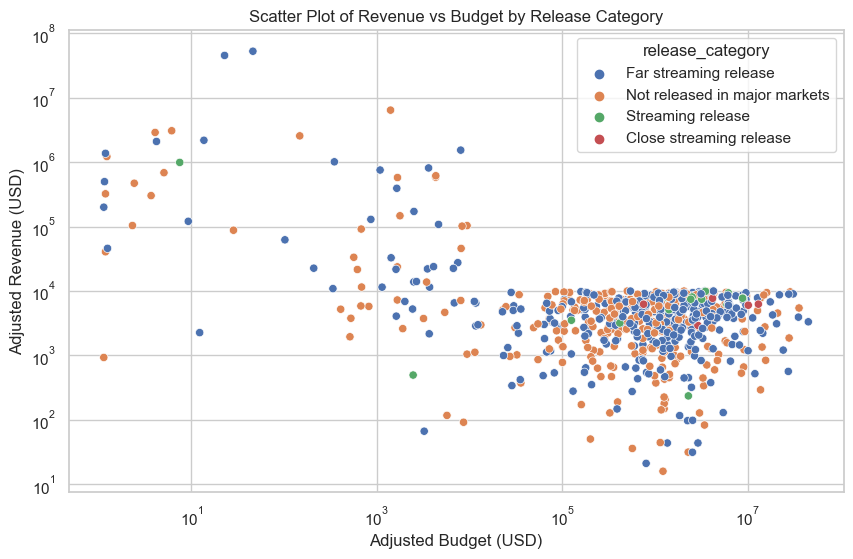

In [122]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
scatter = sns.scatterplot(x='budget_usd_adj', y='revenue_usd_adj', hue='release_category', data=movie[movie['is_within_scope'] == False])

# Adding plot title and labels
plt.title('Scatter Plot of Revenue vs Budget by Release Category')
plt.xlabel('Adjusted Budget (USD)')
plt.ylabel('Adjusted Revenue (USD)')

# Optional: Set log scale for better visibility if numbers vary a lot
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

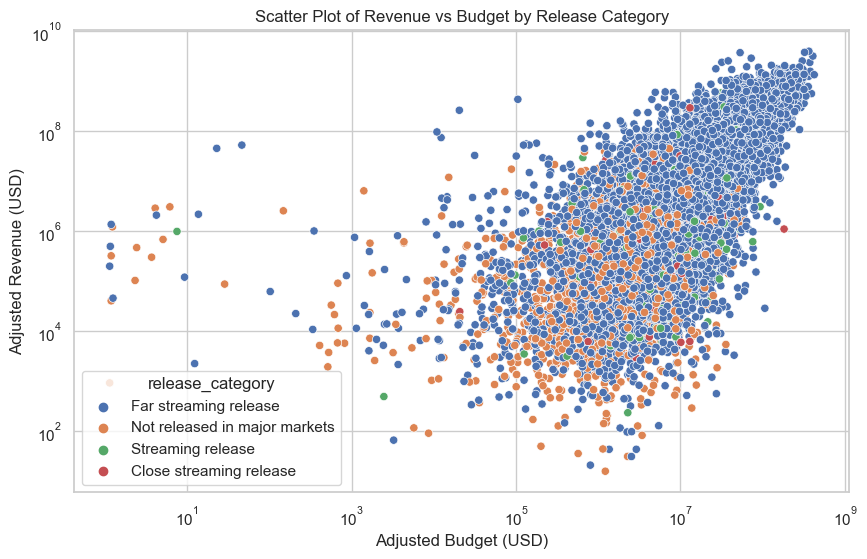

In [123]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
scatter = sns.scatterplot(x='budget_usd_adj', y='revenue_usd_adj', hue='release_category', data=movie)

# Adding plot title and labels
plt.title('Scatter Plot of Revenue vs Budget by Release Category')
plt.xlabel('Adjusted Budget (USD)')
plt.ylabel('Adjusted Revenue (USD)')

# Optional: Set log scale for better visibility if numbers vary a lot
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

# Outliers

In [124]:
#movie = movie[movie['release_category'] != 'Not released in major markets']

In [125]:
# Determining outliers for specific columns and appending the information to the dataset

# Selecting the specific columns for outlier analysis
specific_columns = ['revenue_usd_adj', 'budget_usd_adj', 'surplus', 'ratio_adj','roi']

# Calculating IQR for the specific columns
Q1_specific = movie[specific_columns].quantile(0.25)
Q3_specific = movie[specific_columns].quantile(0.75)

Q1_specific_log = np.log(movie[specific_columns]).quantile(0.25)
Q3_specific_log = np.log(movie[specific_columns]).quantile(0.75)

IQR_specific = Q3_specific - Q1_specific
IQR_specific_log = Q3_specific_log - Q1_specific_log

# Creating outlier flags for each specific column
for column in specific_columns:
    lower_bound = Q1_specific[column] - 1.5 * IQR_specific[column]
    upper_bound = Q3_specific[column] + 1.5 * IQR_specific[column]
    lower_bound_log = Q1_specific_log[column] - 0.75 * IQR_specific_log[column]
    upper_bound_log = Q3_specific_log[column] + 0.75 * IQR_specific_log[column]
    movie[f'{column}_outlier'] = ((movie[column] < lower_bound) | (movie[column] > upper_bound))
    movie[f'{column}_outlier_log'] = ((np.log(movie[column]) < lower_bound_log) | (np.log(movie[column]) > upper_bound_log))

In [126]:
# showing the outliers
outliers = movie[movie['roi_outlier']]

In [127]:
movie

movie_id    imdb_id  year               release_date  quarter  \
0         47652  tt0865925  2006  2006-09-01 00:00:00+00:00        3   
1        127316  tt1017437  2008  2008-01-01 00:00:00+00:00        1   
2         80679  tt1217259  2010  2010-05-14 00:00:00+00:00        2   
3         25149  tt0407814  2006  2006-04-27 00:00:00+00:00        2   
4        212968  tt2276023  2013  2013-04-05 00:00:00+00:00        2   
...         ...        ...   ...                        ...      ...   
12413     29514  tt0100827  1990  1990-01-25 00:00:00+00:00        1   
12414     11470  tt0211443  2001  2001-07-24 00:00:00+00:00        3   
12415      9542  tt0091209  1986  1986-02-21 00:00:00+00:00        1   
12416     10007  tt0437179  2006  2006-05-19 00:00:00+00:00        2   
12417      9696  tt0296042  2001  2001-12-22 00:00:00+00:00        4   

                    original_title  is_released is_released_US  \
0                     Off the Grid         True           True   
1               Gigantes de Valdés        False          False   
2            In/Significant Others         True           True   
3                   Full Grown Men        False          False   
4      The United States of Autism         True           True   
...                            ...          ...            ...   
12413          Due occhi diabolici         True           True   
12414                      Jason X         True           True   
12415                  The Hitcher         True           True   
12416                  See No Evil         True           True   
12417                         殺し屋1         True           True   

       days_from_us_release  runtime  ...  revenue_usd_adj_outlier  \
0                    9999.0      110  ...                    False   
1                    9999.0      100  ...                    False   
2                    9999.0      100  ...                    False   
3                    9999.0       78  ...                    False   
4                    9999.0       93  ...                    False   
...                     ...      ...  ...                      ...   
12413                3666.0      120  ...                    False   
12414                9999.0       91  ...                    False   
12415                9999.0       98  ...                    False   
12416                 479.0       84  ...                    False   
12417                9999.0      129  ...                    False   

       revenue_usd_adj_outlier_log  budget_usd_adj_outlier  \
0                            False                   False   
1                            False                   False   
2                             True                   False   
3                            False                   False   
4                            False                   False   
...                            ...                     ...   
12413                        False                   False   
12414                        False                   False   
12415                        False                   False   
12416                        False                   False   
12417                        False                   False   

       budget_usd_adj_outlier_log  surplus_outlier  surplus_outlier_log  \
0                           False            False                False   
1                           False            False                False   
2                            True            False                False   
3                           False            False                False   
4                            True            False                False   
...                           ...              ...                  ...   
12413                       False            False                False   
12414                       False            False                False   
12415                       False            False                False   
12416        

Number of outliers in revenue_usd_adj_outlier:  1715
Number of outliers in revenue_usd_adj_outlier_log:  604
Number of outliers in budget_usd_adj_outlier:  1106
Number of outliers in budget_usd_adj_outlier_log:  820
Number of outliers in surplus_outlier:  3018
Number of outliers in surplus_outlier_log:  358
Number of outliers in ratio_adj_outlier:  1114
Number of outliers in ratio_adj_outlier_log:  1211
Number of outliers in roi_outlier:  1114
Number of outliers in roi_outlier_log:  436


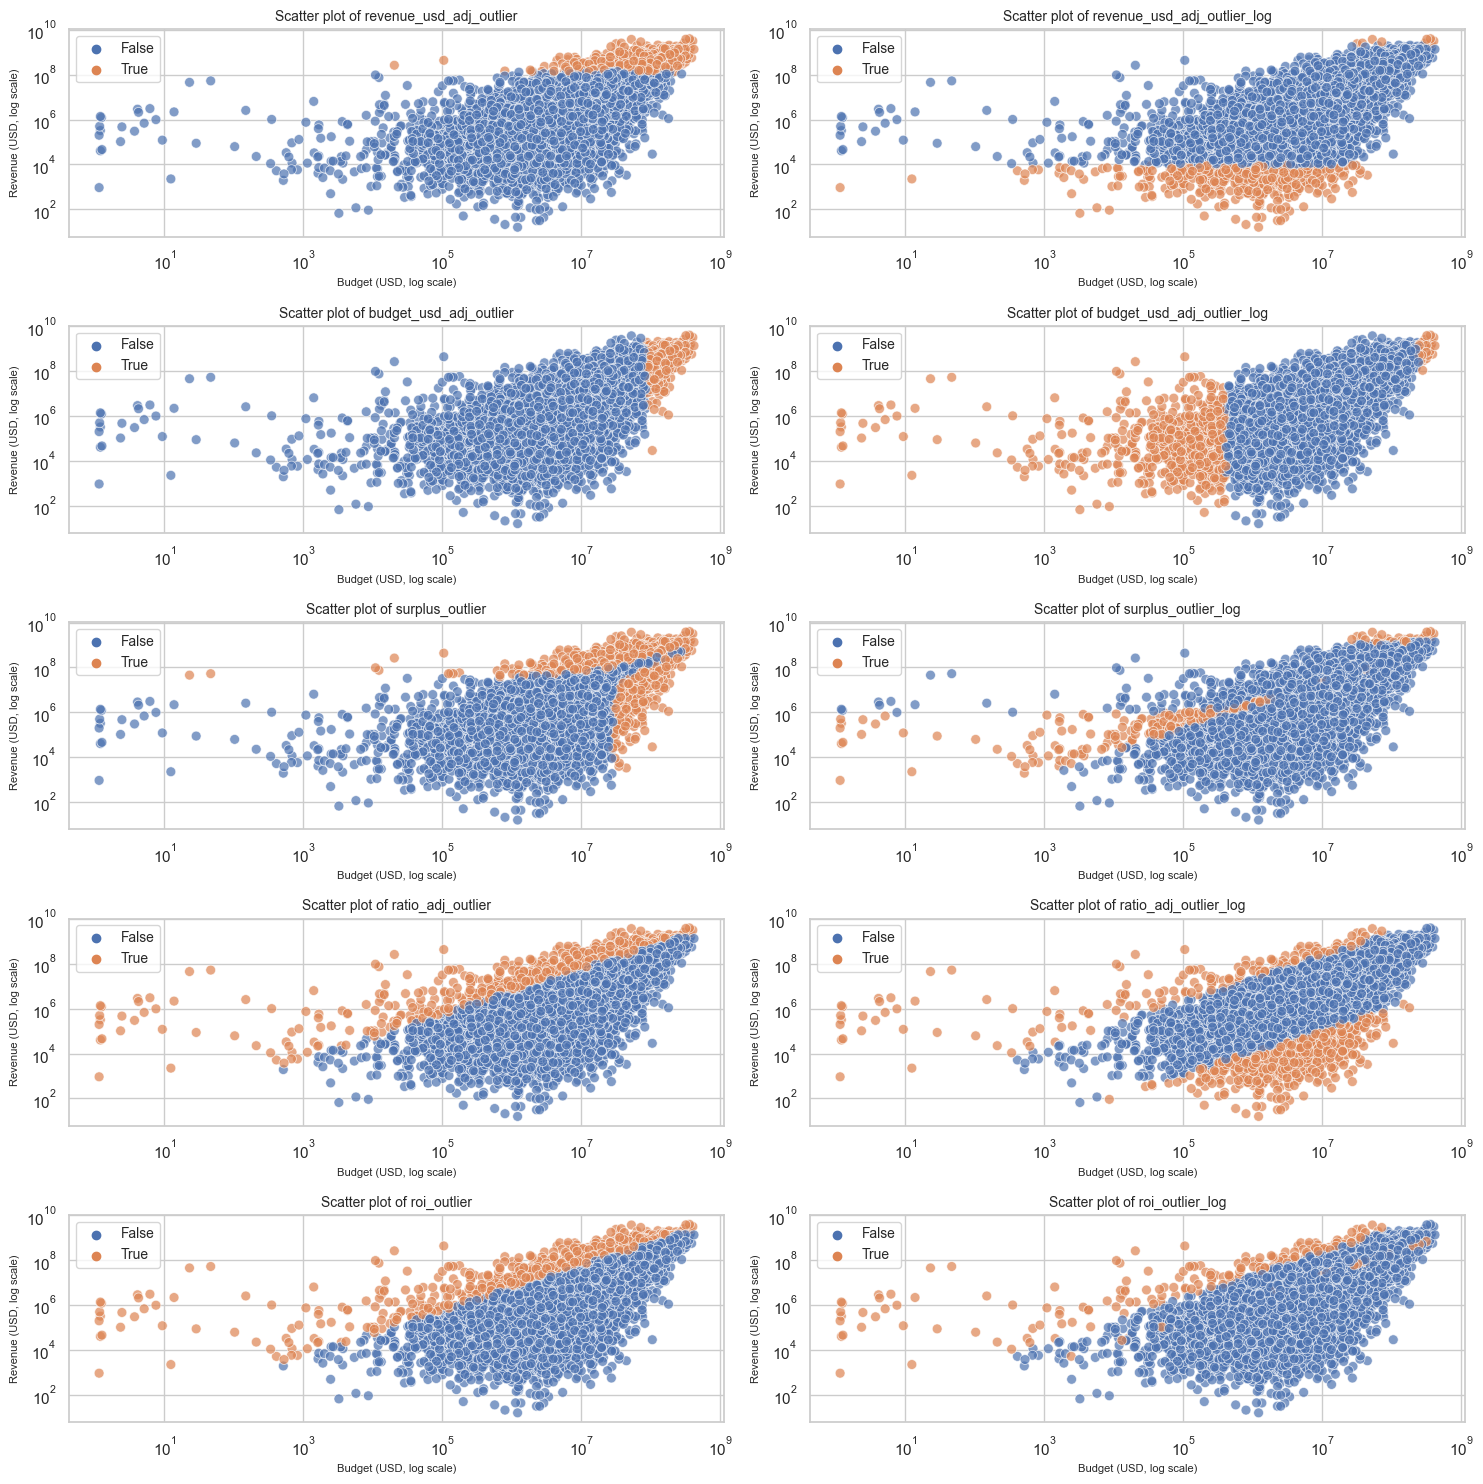

In [128]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

for i, ax in zip(['revenue_usd_adj_outlier', 'revenue_usd_adj_outlier_log',
                'budget_usd_adj_outlier', 'budget_usd_adj_outlier_log',
                'surplus_outlier', 'surplus_outlier_log',
                'ratio_adj_outlier', 'ratio_adj_outlier_log',
                'roi_outlier', 'roi_outlier_log'], axs.flatten()):
    print(f'Number of outliers in {i}: ', len(movie[movie[i]]))
    # Plotting the scatter plot
    sns.scatterplot(data=movie, x='budget_usd_adj', y='revenue_usd_adj', hue=i, ax=ax, alpha=0.7, s=50)
    ax.set_title(f'Scatter plot of {i}', fontsize=10)
    ax.set_xlabel('Budget (USD, log scale)', fontsize=8)
    ax.set_ylabel('Revenue (USD, log scale)', fontsize=8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


Number of outliers in revenue_usd_adj_outlier:  1715
Number of outliers in revenue_usd_adj_outlier_log:  604
Number of outliers in budget_usd_adj_outlier:  1106
Number of outliers in budget_usd_adj_outlier_log:  820
Number of outliers in surplus_outlier:  3018
Number of outliers in surplus_outlier_log:  358
Number of outliers in ratio_adj_outlier:  1114
Number of outliers in ratio_adj_outlier_log:  1211
Number of outliers in roi_outlier:  1114
Number of outliers in roi_outlier_log:  436


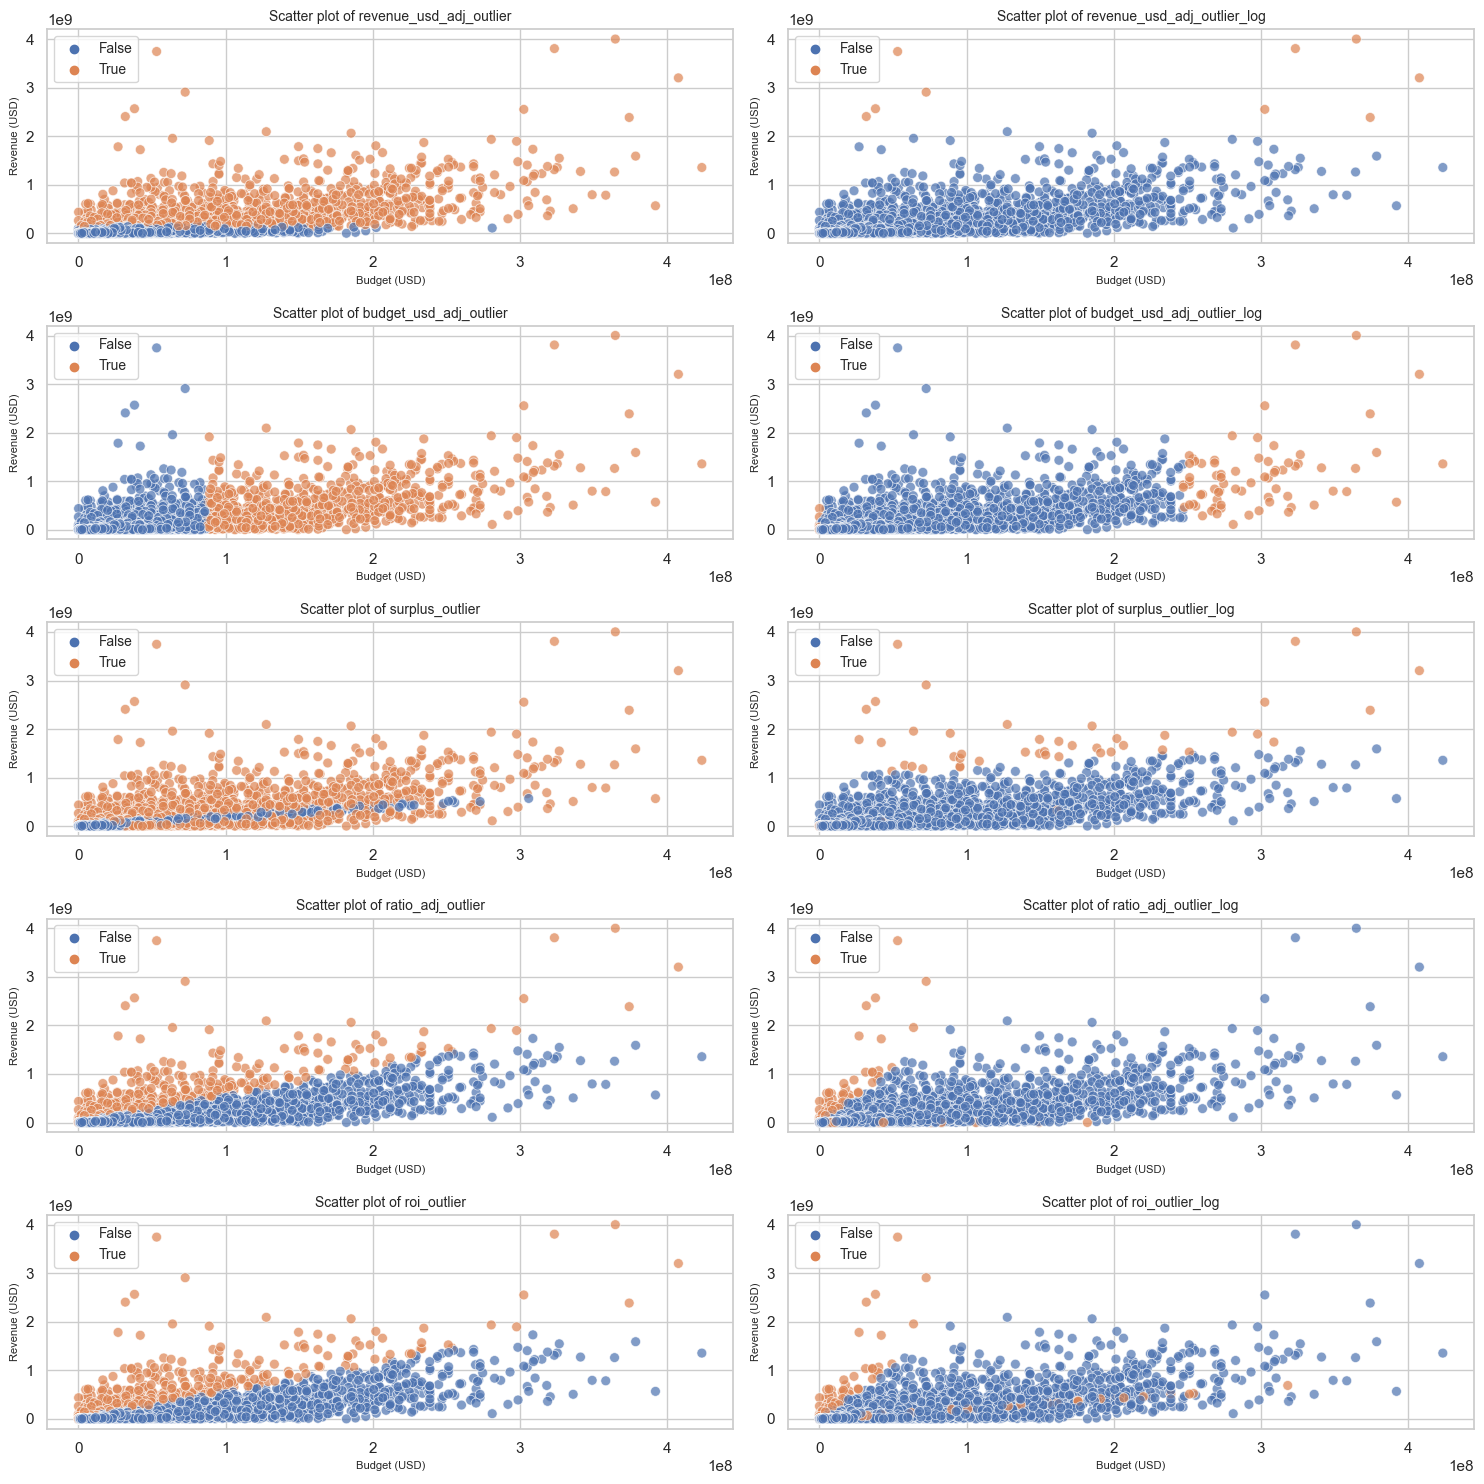

In [129]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

for i, ax in zip(['revenue_usd_adj_outlier', 'revenue_usd_adj_outlier_log',
                'budget_usd_adj_outlier', 'budget_usd_adj_outlier_log',
                'surplus_outlier', 'surplus_outlier_log',
                'ratio_adj_outlier', 'ratio_adj_outlier_log',
                'roi_outlier', 'roi_outlier_log'], axs.flatten()):
    print(f'Number of outliers in {i}: ', len(movie[movie[i]]))
    # Plotting the scatter plot
    sns.scatterplot(data=movie, x='budget_usd_adj', y='revenue_usd_adj', hue=i, ax=ax, alpha=0.7, s=50)
    ax.set_title(f'Scatter plot of {i}', fontsize=10)
    ax.set_xlabel('Budget (USD)', fontsize=8)
    ax.set_ylabel('Revenue (USD)', fontsize=8)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


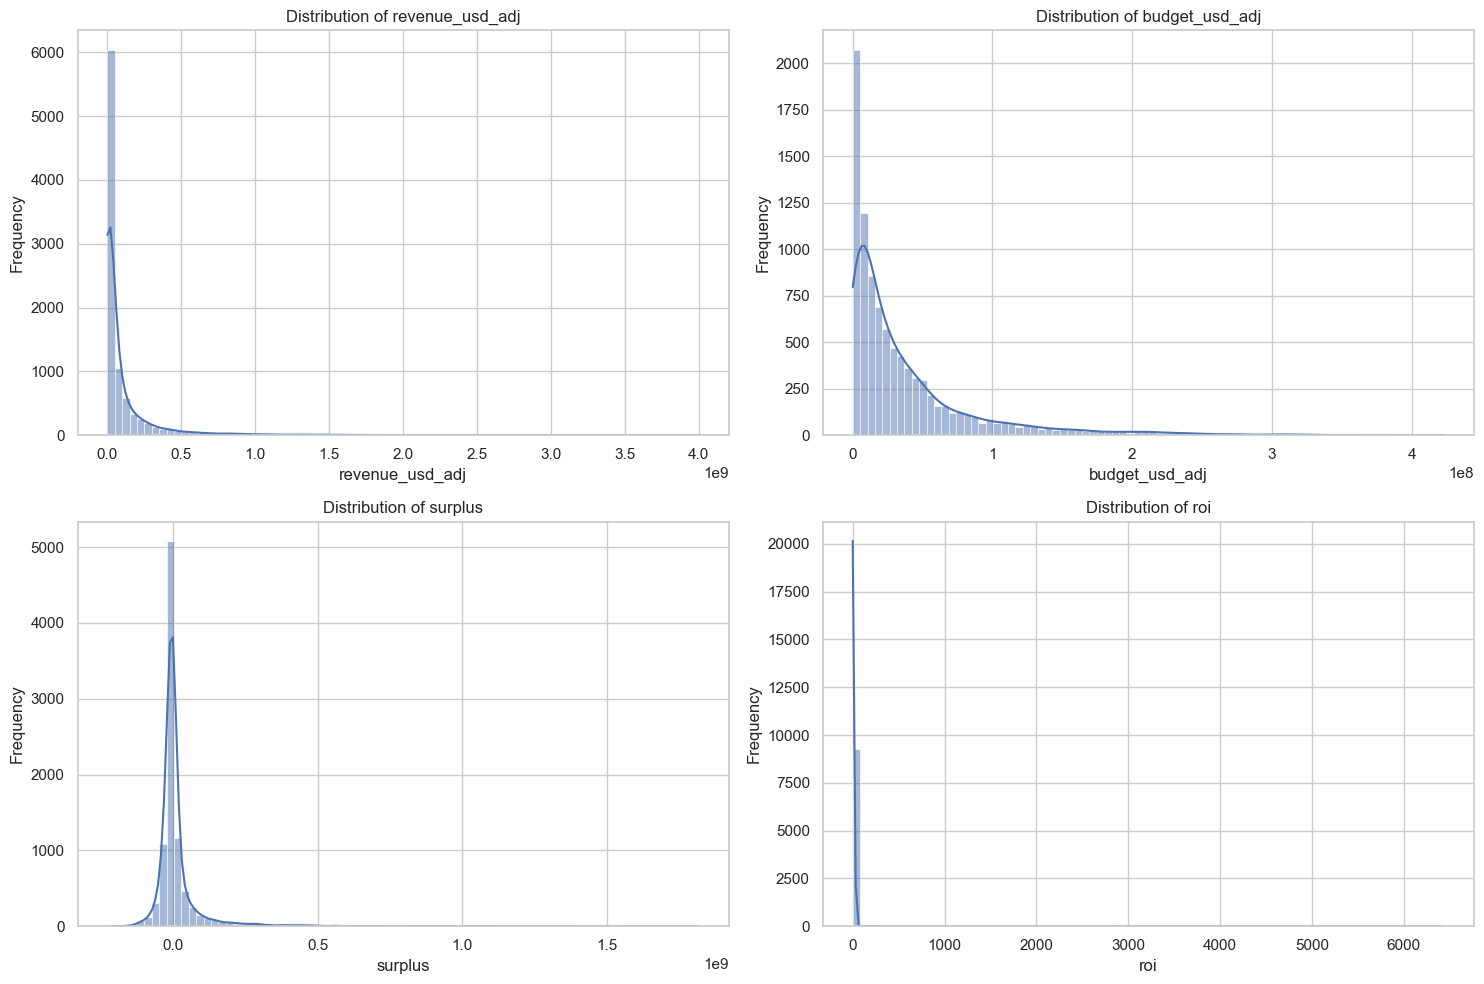

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting the specific columns for distribution analysis
distribution_columns = ['revenue_usd_adj','budget_usd_adj', 'surplus', 'roi']

# Plotting histograms for each column
plt.figure(figsize=(15, 10))
for i, column in enumerate(distribution_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(movie[movie.is_within_scope & (movie.release_category == 'Far streaming release')][column], bins=80, kde=True)
    plt.title(f'Distribution of {column}')
    # Can we do log scale in the x axis?
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


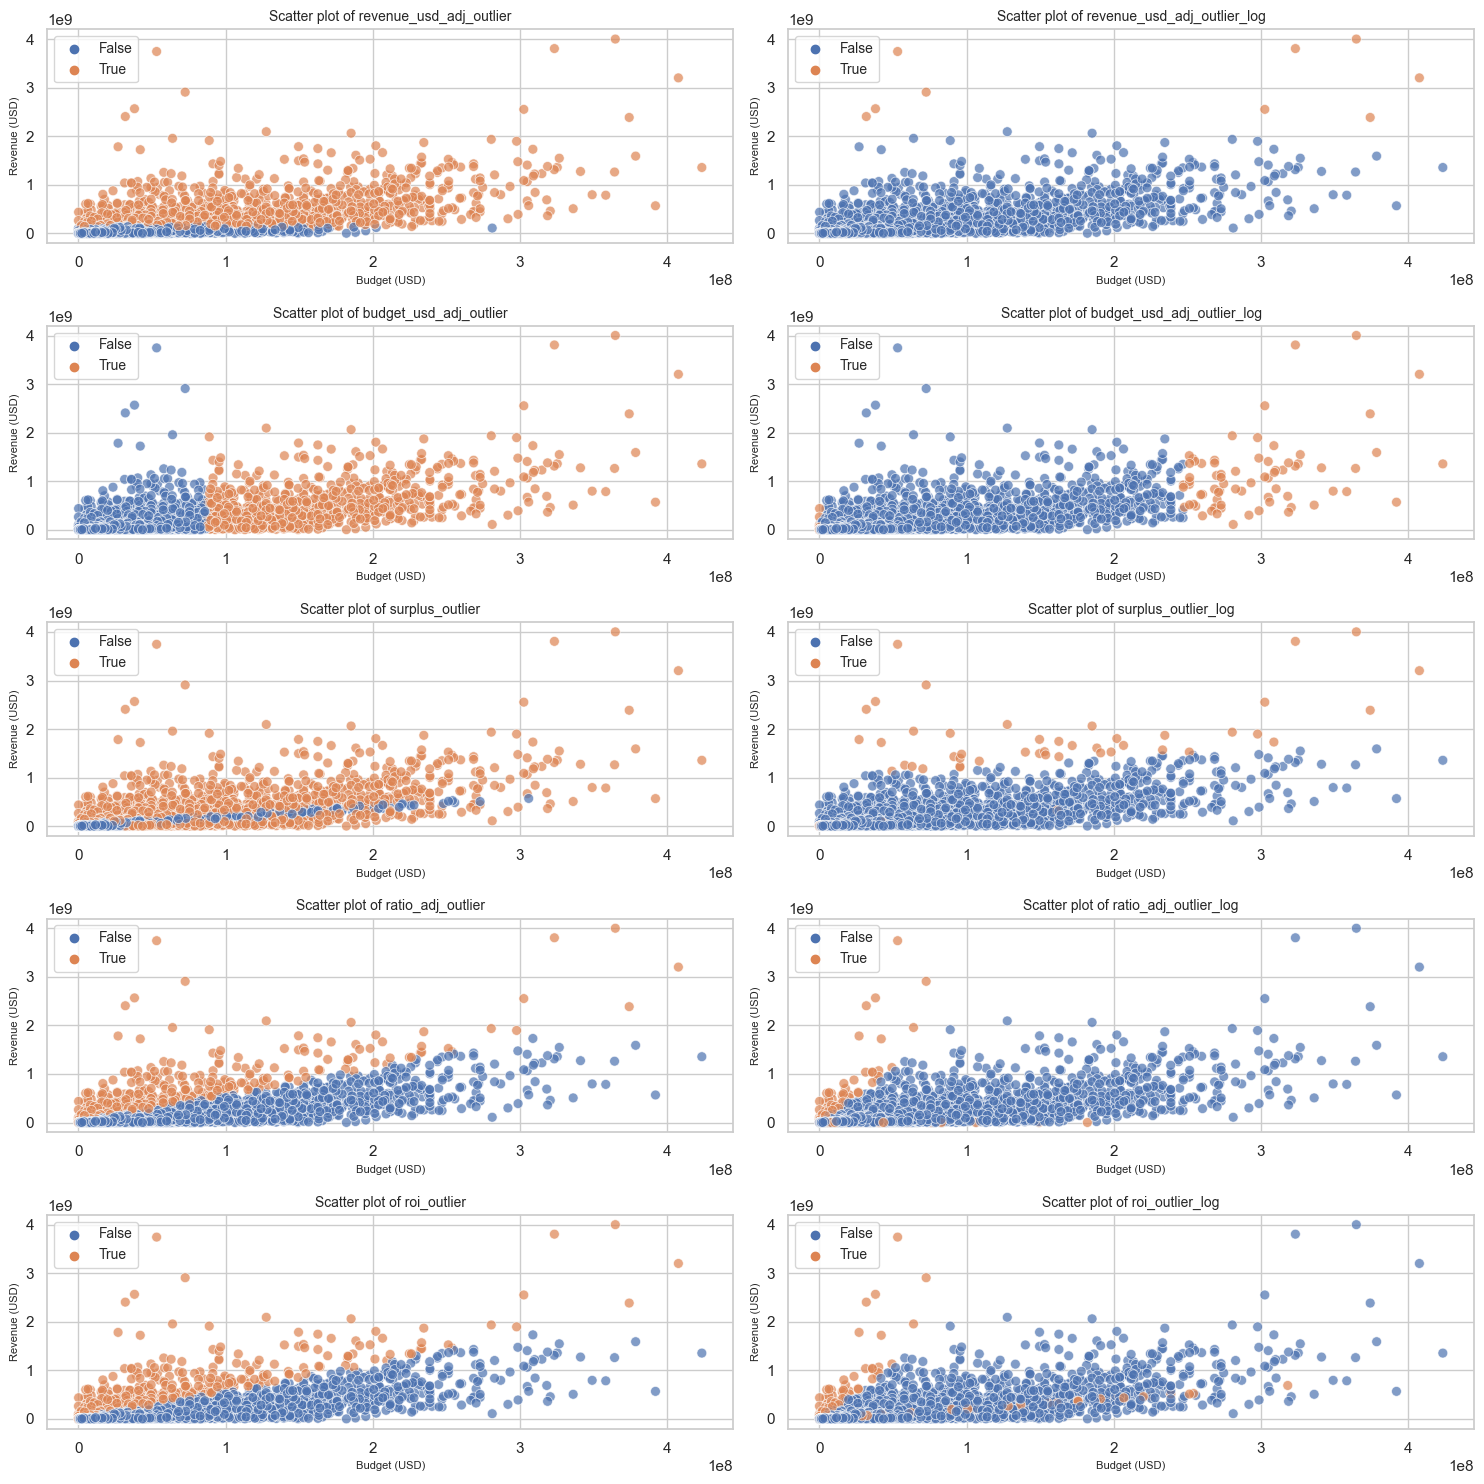

In [131]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# First, adding log-transformed columns for better visualization


# Setting up the figure for scatter plots
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

# Defining the columns to be plotted
columns_to_plot = ['revenue_usd_adj_outlier', 'revenue_usd_adj_outlier_log',
                'budget_usd_adj_outlier', 'budget_usd_adj_outlier_log',
                'surplus_outlier', 'surplus_outlier_log',
                'ratio_adj_outlier', 'ratio_adj_outlier_log',
                'roi_outlier', 'roi_outlier_log']  # Add 'roi_outlier' and 'roi_outlier_log' if applicable

# Creating scatter plots
for i, ax in zip(columns_to_plot, axs.flatten()):
    sns.scatterplot(data=movie, x='budget_usd_adj', y='revenue_usd_adj', hue=i, ax=ax, alpha=0.7, s=50)
    ax.set_title(f'Scatter plot of {i}', fontsize=10)
    ax.set_xlabel('Budget (USD)', fontsize=8)
    ax.set_ylabel('Revenue (USD)', fontsize=8)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


# Genres

In [132]:
# Join the movie and the genre table
movie_genre = movie.merge(genres, how='left', on='movie_id')

In [133]:
# Lets do some EDA on the genres
# How many genres are there?
print('Number of genres: ', len(movie_genre['name'].unique()))
# How many movies are there in each genre?
print('Number of movies in each genre: ')
print(movie_genre['name'].value_counts())
# How many movies charecterized by more than one genre?



Number of genres:  20
Number of movies in each genre: 
name
drama              6031
comedy             4284
thriller           2801
action             2462
romance            2003
crime              1570
adventure          1503
horror             1252
family             1104
science_fiction     923
fantasy             913
mystery             795
history             550
animation           547
documentary         480
war                 371
music               353
western             120
tv_movie              9
Name: count, dtype: int64


In [134]:
# Number genres per movie
print('Number of genres per movie: {0:.2f}'.format(movie_genre.groupby('movie_id')['name'].count().mean()))

Number of genres per movie: 2.26


In [135]:
# Can you give some basic statistics per genre for the ratio and the ROI?
print('Basic statistics per genre for the ratio and the ROI: ')
display(movie_genre.groupby('name')[['ratio_adj', 'roi']].describe().style.format("{:,.2f}"))


Basic statistics per genre for the ratio and the ROI: 


In [136]:
# Can you give some basic statistics per genre for the ratio and the ROI?
print('Basic statistics per US theatrical release for the ratio and the ROI: ')
display(movie_genre.groupby('name')[['ratio_adj', 'roi']].describe().style.format("{:,.2f}"))

Basic statistics per US theatrical release for the ratio and the ROI: 


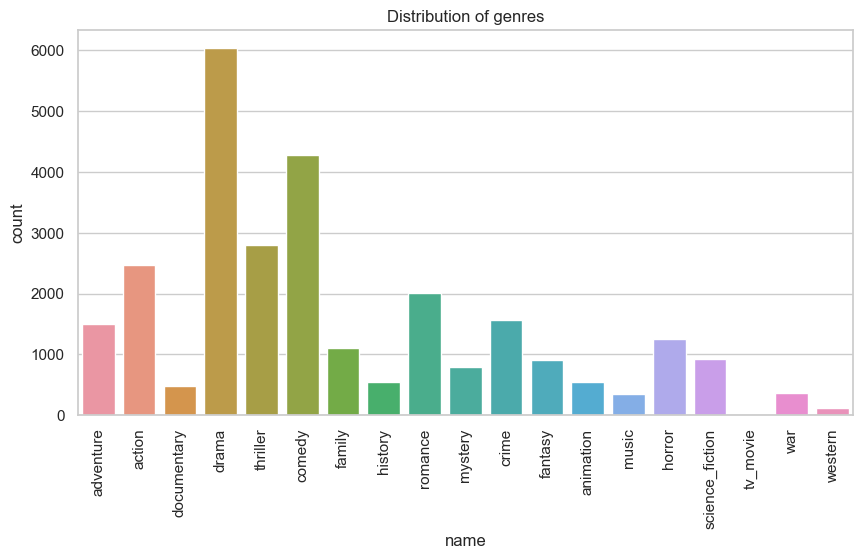

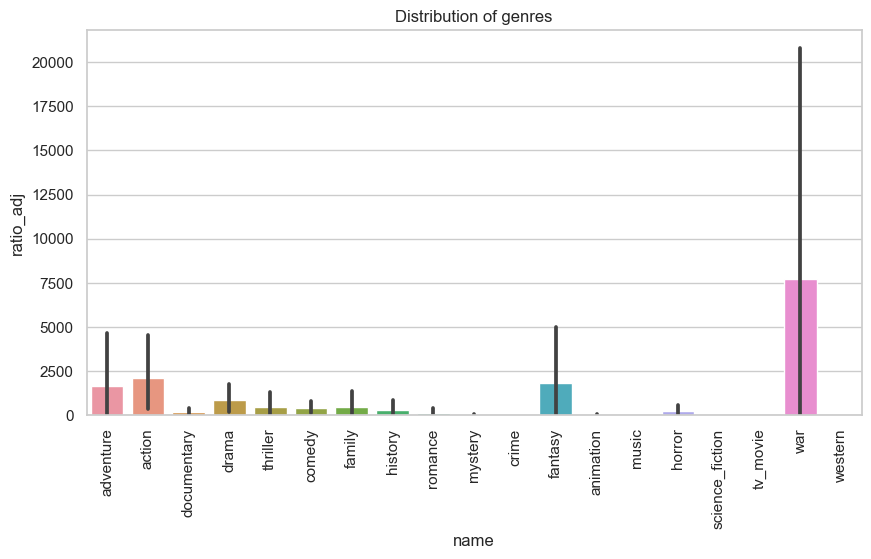

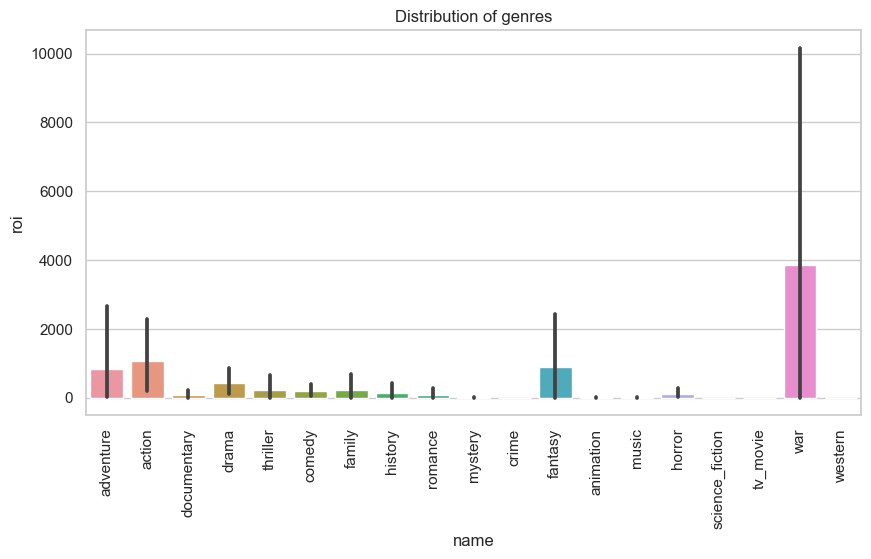

In [137]:
# Distribution of the genres?
plt.figure(figsize=(10, 5))
plt.title('Distribution of genres')
sns.countplot(data=movie_genre, x='name')
plt.xticks(rotation=90)
plt.show()

# Average ratio per genre
plt.figure(figsize=(10, 5))
plt.title('Distribution of genres')
sns.barplot(data=movie_genre, x='name', y='ratio_adj')
plt.xticks(rotation=90)
plt.show()

# Average ROI per genre
plt.figure(figsize=(10, 5))
plt.title('Distribution of genres')
sns.barplot(data=movie_genre, x='name', y='roi')
plt.xticks(rotation=90)
plt.show()

# Production Companies

In [138]:
# Join the movie and the production companies table
movie_production_companies = movie.merge(production_companies, how='left', on='movie_id')

In [139]:
# Number of production companies
print('Number of production companies: ', len(movie_production_companies['company_name'].unique()))
# Number of parent companies (companies that own other companies)
print('Number of parent companies: ', len(movie_production_companies['parent_name'].unique()))

Number of production companies:  11305
Number of parent companies:  11289


In [140]:
# Number of production companies per movie
print('Number of production companies per movie: {0:.2f}'.format(movie_production_companies.groupby('movie_id')['company_name'].count().mean()))

Number of production companies per movie: 2.59


In [141]:
# Biggest production companies (by number of movies and by revenue)
biggest_companies = movie_production_companies.groupby('company_name').agg({'movie_id': 'count', 'revenue_usd_adj': 'sum'})
biggest_companies.columns = ['Number of Movies', 'Total Revenue']
biggest_companies = biggest_companies.sort_values(by='Number of Movies', ascending=False).head(10)
display(biggest_companies)

Number of Movies  Total Revenue
company_name                                         
warner_bros_pictures               558   1.233317e+11
universal_pictures                 548   1.103745e+11
columbia_pictures                  426   8.020899e+10
paramount                          414   9.324288e+10
20th_century_fox                   360   9.771893e+10
canal_                             246   1.174787e+10
new_line_cinema                    245   3.978898e+10
metro_goldwyn_mayer                206   2.424179e+10
touchstone_pictures                176   2.652981e+10
walt_disney_pictures               173   7.143699e+10

In [142]:
# Biggest parent production companies (by number of movies and by revenue)
biggest_parent_companies = movie_production_companies.groupby('parent_name').agg({'movie_id': 'count', 'revenue_usd_adj': 'sum'})
biggest_parent_companies.columns = ['Number of Movies', 'Total Revenue']
biggest_parent_companies = biggest_parent_companies.sort_values(by='Number of Movies', ascending=False).head(10)
display(biggest_parent_companies)

Number of Movies  Total Revenue
parent_name                                               
warner_bros_entertainment               619   1.292570e+11
universal_pictures                      550   1.103891e+11
columbia_pictures                       426   8.020899e+10
sony_pictures                           375   6.866819e+10
20th_century_fox                        362   9.776363e+10
new_line_cinema                         277   4.021105e+10
canal_                                  246   1.174787e+10
walt_disney_pictures                    194   9.103916e+10
touchstone_pictures                     176   2.652981e+10
miramax                                 156   1.261194e+10

In [143]:
# Companies with the most subsidiaries
subsidiaries = movie_production_companies.groupby('parent_name').agg({'company_name': 'nunique'})
subsidiaries.columns = ['Number of Subsidiaries']
subsidiaries = subsidiaries.sort_values(by='Number of Subsidiaries', ascending=False).head(10)
display(subsidiaries)

Number of Subsidiaries
parent_name                                      
sony_pictures                                   4
universal_pictures                              3
walt_disney_pictures                            2
europacorp                                      2
new_line_cinema                                 2
warner_bros_entertainment                       2
lotte_entertainment                             2
ard                                             2
regency_enterprises                             2
x_filme_creative_pool                           2

# Keywords

In [144]:
movie_keywords = movie.merge(keywords, how='left', on='movie_id')

In [145]:
# Lets do some EDA on the keywords
# How many keywords are there?
print('Number of keywords: ', len(movie_keywords['keyword_name'].unique()))

Number of keywords:  13264


In [146]:
# On average, how many keywords are there per movie?
print('Average number of keywords per movie: ', movie_keywords.groupby('movie_id')['keyword_name'].count().mean())

Average number of keywords per movie:  5.773925663146013


In [147]:
# The most popular keywords (by number of movies and by revenue)
popular_keywords = movie_keywords.groupby('keyword_name').agg({'movie_id': 'count', 'revenue_usd_adj': 'sum'})
popular_keywords.columns = ['Number of Movies', 'Total Revenue']
popular_keywords = popular_keywords.sort_values(by='Number of Movies', ascending=False).head(10)
display(popular_keywords)

Number of Movies  Total Revenue
keyword_name                                           
woman_director                       910   3.692772e+10
based_on_novel_or_book               689   1.025128e+11
murder                               499   3.470874e+10
duringcreditsstinger                 386   1.062524e+11
independent_film                     374   2.952950e+09
violence                             364   4.153107e+10
new_york_city                        325   4.473633e+10
based_on_a_true_story                309   2.867376e+10
biography                            309   1.860688e+10
revenge                              266   2.874346e+10

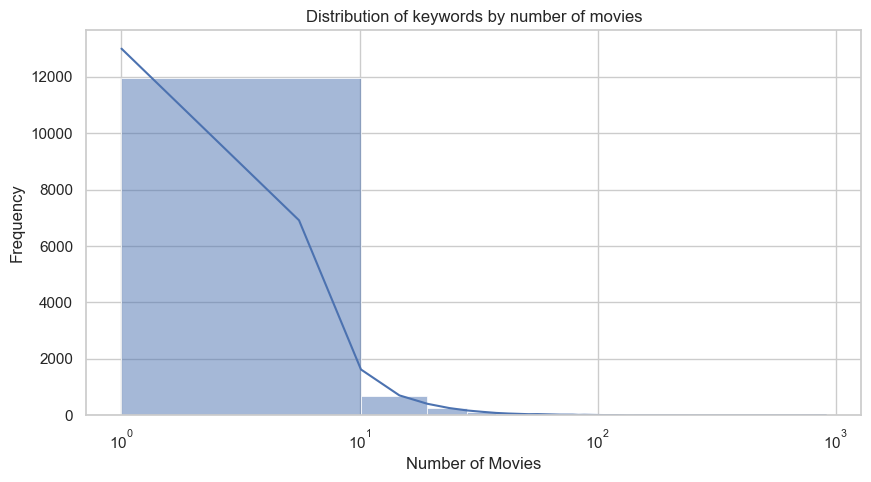

In [148]:
# Can we do a histogram for the distribution of keywords by the number of movies they appear in? Lets do it in log scale
# Can we also show the cumulative distribution?
plt.figure(figsize=(10, 5))
plt.title('Distribution of keywords by number of movies')
sns.histplot(movie_keywords.groupby('keyword_name')['movie_id'].count(), bins=100, kde=True)
plt.xlabel('Number of Movies')
plt.ylabel('Frequency')
plt.xscale('log')
plt.show()


# Time analysis

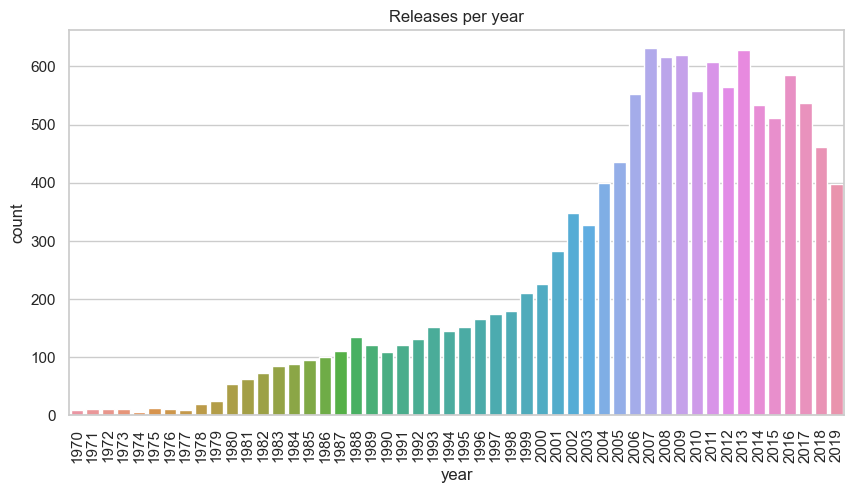

In [149]:
# Lets do some EDA in refards to release date
# Release count per year
plt.figure(figsize=(10, 5))
plt.title('Releases per year')
sns.countplot(data=movie, x='year')
plt.xticks(rotation=90)
plt.show()

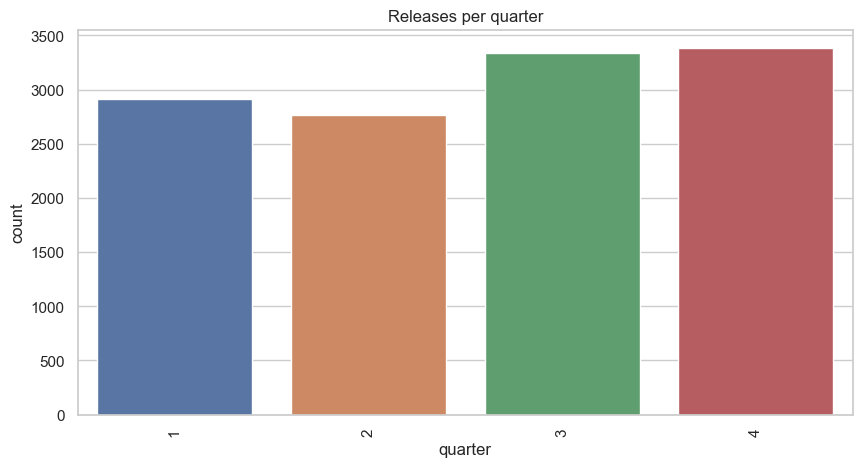

In [150]:
# Release count per quarter
plt.figure(figsize=(10, 5))
plt.title('Releases per quarter')
sns.countplot(data=movie, x='quarter')
plt.xticks(rotation=90)
plt.show()
